In [3]:
import sqlite3
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

In [6]:
##Reading Data from the sql Database into pandas 
cnx = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [17]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [19]:
df.shape

(183978, 42)

###### columns used as a features

In [7]:
features = [
       'potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes']

###### calculating overall rating of player using features

In [8]:
t = ['overall_rating']

In [31]:
df = df.dropna()

###### Cleaning the Data

In [32]:
#Create a new dataframe after dropping some columns which are not useful to predict player overall ratings
soccer_data = df.drop(["id", "player_fifa_api_id", "player_api_id", "date"], axis = 1)

#Check whether there are duplicates entries present or not
soccer_data.duplicated().any()

True

###### Drop duplicates entries from soccer_data dataframe

In [33]:
soccer_data.drop_duplicates(inplace=True)

###### Check dimention of data after cleaning

In [34]:
soccer_data.shape

(136284, 38)

In [35]:
X = soccer_data[features]

In [36]:
X.describe()

,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,...,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000,136284.000000
mean,74.014000,55.578975,50.239397,57.765042,63.017031,49.912418,59.576583,53.356748,49.785000,57.648139,...,58.512503,55.374490,47.306404,50.922786,48.537752,14.943133,16.220437,21.328329,16.291692,16.627374
std,6.541181,17.467346,19.286798,16.770756,14.276852,18.539089,17.968145,18.476876,18.060433,14.453001,...,15.206014,15.763376,21.566817,21.776353,21.902027,17.284401,16.255829,21.906144,16.502164,17.633108
min,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,3.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,69.000000,46.000000,34.000000,50.000000,58.000000,36.000000,52.000000,41.000000,37.000000,50.000000,...,50.000000,46.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,74.000000,60.000000,53.000000,60.000000,66.000000,53.000000,64.000000,56.000000,51.000000,60.000000,...,61.000000,57.000000,52.000000,57.000000,54.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,78.000000,68.000000,66.000000,69.000000,72.000000,64.000000,72.000000,68.000000,64.000000,68.000000,...,69.000000,67.000000,67.000000,70.000000,68.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,94.000000,97.000000,97.000000,...,97.000000,96.000000,94.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


In [37]:
y = soccer_data[t]

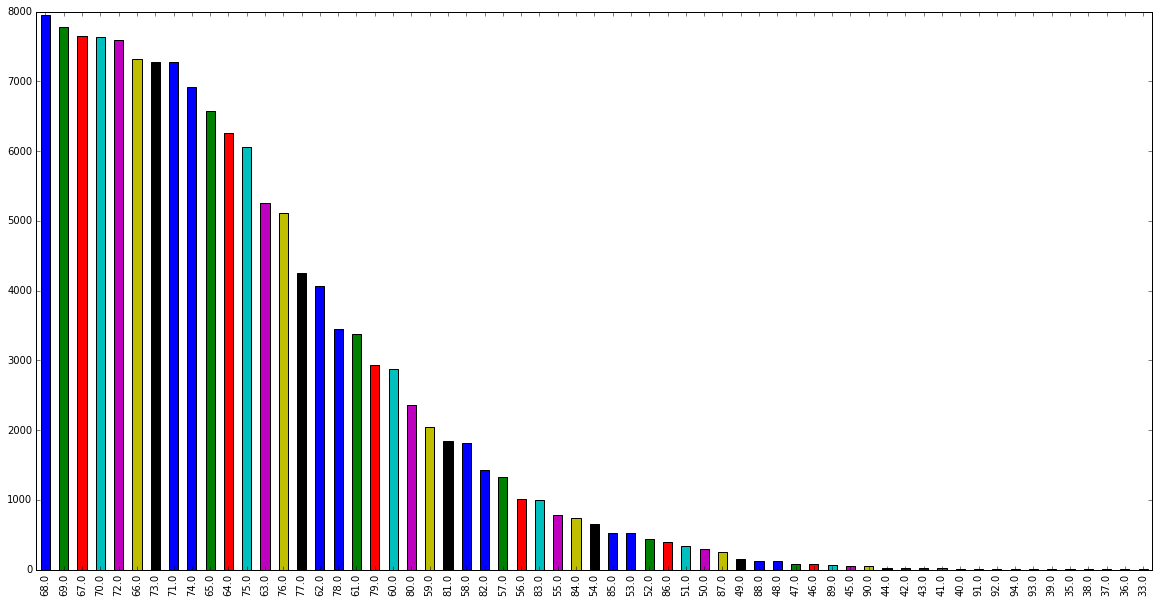

In [38]:
#Visualize column overall_rating of the dataframe
soccer_data['overall_rating'].value_counts()

soccer_data['overall_rating'].value_counts().plot(kind='bar',figsize=(20,10))

###### One row from selected features

In [39]:
X.iloc[1]

potential             66.0
crossing              49.0
finishing             44.0
heading_accuracy      71.0
short_passing         61.0
volleys               44.0
dribbling             51.0
curve                 45.0
free_kick_accuracy    39.0
long_passing          64.0
ball_control          49.0
acceleration          60.0
sprint_speed          64.0
agility               59.0
reactions             47.0
balance               65.0
shot_power            55.0
jumping               58.0
stamina               54.0
strength              76.0
long_shots            35.0
aggression            63.0
interceptions         41.0
positioning           45.0
vision                54.0
penalties             48.0
marking               65.0
standing_tackle       66.0
sliding_tackle        69.0
gk_diving              6.0
gk_handling           11.0
gk_kicking            10.0
gk_positioning         8.0
gk_reflexes            8.0
Name: 2, dtype: float64

###### target values

In [40]:
y

,overall_rating
0,67.0
2,62.0
3,61.0
5,74.0
6,74.0
7,73.0
8,73.0
10,73.0
11,74.0
12,73.0


###### Spliting Dataset into Training and Testing Datasets 

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [42]:
from sklearn.preprocessing import StandardScaler, Normalizer, scale
df_x1 = scale(X_train)

###### Fiting a model to the training set using lenear regression

In [43]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

###### Performing Prediction using Linear Regression Model

In [44]:
y_prediction = regressor.predict(X_test)
y_prediction

array([[ 59.76738886],
       [ 73.53996166],
       [ 73.03506767],
       ..., 
       [ 78.65548925],
       [ 66.01785786],
       [ 65.68591129]])

###### mean of the expected target value in test set ?

In [45]:
y_test.describe()

,overall_rating
count,40886.000000
mean,69.318104
std,6.856139
min,33.000000
25%,65.000000
50%,69.000000
75%,74.000000
max,94.000000


###### Evaluating Linear Regression Accuracy using Root Mean Square Error 

In [46]:
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))

In [49]:
print(RMSE)

2.759163559794494


In [50]:
# Apply xgboost model on the dataset
Boosting = xgb.XGBRegressor(n_estimators=200,learning_rate=1)
Boosting.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

###### checking accuracy using Regressor_OLS

In [53]:
import statsmodels.formula.api as sm
X = np.append(arr = np.ones((136284, 1)).astype(int), values = X, axis = 1)
X_opt = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         overall_rating   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                 2.069e+04
Date:                Tue, 20 Nov 2018   Prob (F-statistic):               0.00
Time:                        23:23:37   Log-Likelihood:            -3.3164e+05
No. Observations:              136284   AIC:                         6.633e+05
Df Residuals:                  136249   BIC:                         6.637e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3290      0.054    -24.560      0.000      -1.435      -1.223
x1            -1.3290      0.054    -24.560      0.000      -1.435      -1.223
x2             0.3879      0.002    230.361      0.000       0.385       0.391
x3             0.0194      0.001     20.333      0.000       0.018       0.021
x4             0.0106      0.001     10.180      0.000       0.009       0.013
x5             0.0678      0.001     72.571      0.000       0.066       0.070
x6             0.0495      0.002     31.228      0.000       0.046       0.053
x7             0.0046      0.001      4.939      0.000       0.003       0.006
x8            -0.0138      0.001    -10.349      0.000      -0.016      -0.011
x9             0.0128      0.001     14.106      0.000       0.011       0.015
x10            0.0127      0.001     15.909      0.000       0.011       0.014
x11            0.0083      0.001      7.774      0.000       0.006       0.010
x12            0.1311      0.002     71.696      0.000       0.128       0.135
x13            0.0067      0.002      4.242      0.000       0.004       0.010
x14            0.0077      0.001      5.136      0.000       0.005       0.011
x15           -0.0108      0.001     -9.288      0.000      -0.013      -0.009
x16            0.2107      0.001    168.590      0.000       0.208       0.213
x17            0.0087      0.001      9.807      0.000       0.007       0.010
x18            0.0160      0.001     15.968      0.000       0.014       0.018
x19            0.0147      0.001     17.677      0.000       0.013       0.016
x20           -0.0073      0.001     -7.821      0.000      -0.009      -0.005
x21            0.0579      0.001     59.716      0.000       0.056       0.060
x22           -0.0134      0.001    -12.931      0.000      -0.015      -0.011
x23            0.0196      0.001     25.017      0.000       0.018       0.021
x24            0.0117      0.001     14.151      0.000       0.010       0.013
x25           -0.0116      0.001    -12.956      0.000      -0.013      -0.010
x26           -0.0044      0.001     -4.461      0.000      -0.006      -0.002
x27            0.0143      0.001     16.913      0.000       0.013       0.016
x28            0.0299      0.001     23.423      0.000       0.027       0.032
x29            0.0016      0.001      1.058      0.290      -0.001       0.004
x30           -0.0254      0.001    -20.333      0.000      -0.028      -0.023
x31            0.1565      0.002     93.423      0.000       0.153       0.160
x32            0.0307      0.002     14.050      0.000       0.026       0.035
x33           -0.0302      0.001    -44.397      0.000      -0.032      -0.029
x34            0.0516      0.002     23.720      0.000       0.047       0.056
x35            0.0250      0.002     11.717      0.000       0.021       0.029
==